# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

PATH_FIGS = os.path.join(REPOSITORY_PATH,'notebooks-scripts','paper1','figs')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data
import random


In [5]:
import uncertainty.metrics as metrics

# Analysis

## Definitions

In [6]:
MODEL_ARC = 'VGG_16'
DATA = 'Cifar100'
NAME = MODEL_ARC +'_' + DATA 

data = torch_data.__dict__[DATA](data_dir = DATA_PATH)
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)
WEIGTH_FILE = 2

Files already downloaded and verified
Files already downloaded and verified


In [7]:
#names = ['natural',
#        'gaussian_blur',
#         'gaussian_noise']
LEVELS = (1,2,3)
corrupted_dataloader = torch_data.CIFAR_C_loader(n = data.n_classes,root = CORRUPTED_DATA_PATH,
                                                levels = LEVELS,natural_data = data.test_data)#,names = names)

## Upload Models

In [8]:
def weights_files(weights_path):
    #Get all weight files in weights_path
    files = [f for f in os.listdir(weights_path) if os.path.isfile(os.path.join(weights_path, f)) and f.endswith(".pt")]
    files = sorted(files)
    return files

def upload_weights(file, weights_path):
    files = weights_files(weights_path)

    if isinstance(file,int):
        weights = files[file]
        weights = os.path.join(weights_path,weights)
    elif file == 'random':
        weights = random.choice(files)
        weights = os.path.join(weights_path,weights)
    elif file == 'max':
        return upload_weights(0, weights_path)
    elif isinstance(file,str):
        if file in files:
            weights = os.path.join(weights_path,file)
        elif file+'.pt' in files:
            weights = os.path.join(weights_path,file+'.pt')
        else: raise Exception("No file named ", file)
    state_dict = torch.load(weights)
    return state_dict


In [9]:
model = model_class(num_classes = data.n_classes, name = NAME,softmax = True).to(dev)
model.load_state_dict(upload_weights(WEIGTH_FILE ,weights_path))
model.eval()
acc_model = TE.model_acc(model,corrupted_dataloader)
rk_model = 1-0.01*acc_model
print(f'Acurácia = {acc_model}')

/home/luis-felipe/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Acurácia = 53.904363636363634


## Plots

### Deterministic

In [10]:
name = NAME + '_Deterministic'
model.eval();

In [11]:
RC = metrics.selective_metrics(model,corrupted_dataloader, c_list = np.arange(0.05,1.05,0.05), name = name)

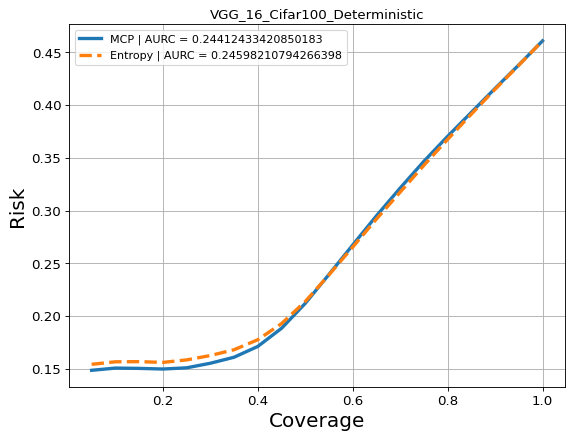

In [12]:
RC.plot_RC(aurc = True)
#plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### Deep Ensemble

In [13]:
from uncertainty.ensemble import DeepEnsemble

##### Upload models

In [14]:
models_dict = defaultdict() #dict to store models
for s in weights_files(weights_path):
    print(s)
    models_dict[s.replace('.pt','')] = model_class(num_classes = data.n_classes).to(dev)
    state_dict = torch.load(os.path.join(weights_path,s))
    models_dict[s.replace('.pt','')].load_state_dict(state_dict)
    models_dict[s.replace('.pt','')].eval()
    models_dict[s.replace('.pt','')].softmax = True


VGG_16_Cifar100_0.pt
VGG_16_Cifar100_1.pt
VGG_16_Cifar100_2.pt
VGG_16_Cifar100_3.pt
VGG_16_Cifar100_4.pt
VGG_16_Cifar100_5.pt
VGG_16_Cifar100_6.pt
VGG_16_Cifar100_7.pt


In [15]:
name = NAME + '_DeepEnsemble'

model_ens = DeepEnsemble(models_dict,name=name).to(dev)
print(f'Ensemble Total Accuracy: {TE.model_acc(model,corrupted_dataloader)}')

Ensemble Total Accuracy: 53.904363636363634


##### Analysis

In [16]:
RC = metrics.selective_metrics(model_ens,corrupted_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

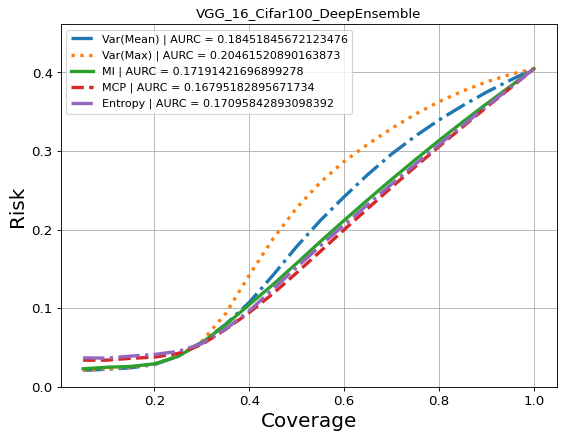

In [17]:
RC.plot_RC(aurc = True)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### MonteCarlo Dropout

In [18]:
from uncertainty.MonteCarlo_Dropout import MonteCarloDropout
N_SAMPLES = 10

#### MCD Ensemble

In [19]:
name = NAME + '_MCD_Ens'
model_mcd = MonteCarloDropout(model,return_uncs = False,n_samples = N_SAMPLES, as_ensemble = True,name = name).to(dev)
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcd,corrupted_dataloader,set_eval = False)}')

MCD Ensemble Total Accuracy: 56.06272727272727


In [20]:
RC = metrics.selective_metrics(model_mcd,corrupted_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

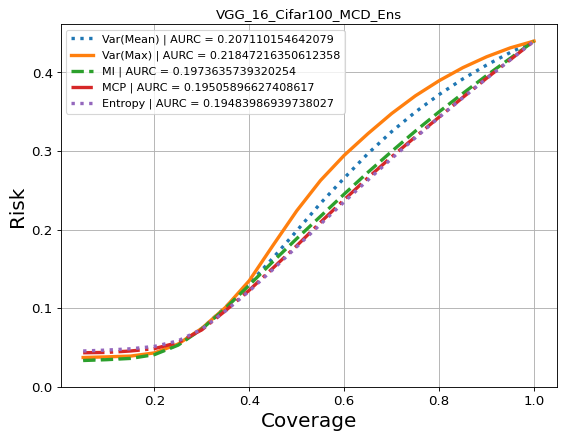

In [21]:
RC.plot_RC(aurc = True)
#plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

#### Deterministic inference

In [22]:
name = NAME + '_MCD_Det'
model_mcd = MonteCarloDropout(model,n_samples = N_SAMPLES, as_ensemble = False,name=name).to(dev)

In [23]:
RC = metrics.selective_metrics(model_mcd,corrupted_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

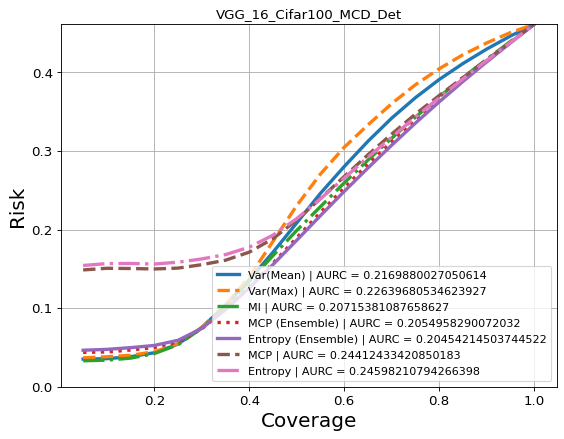

In [24]:
RC.plot_RC(aurc = True)

plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### Monte Carlo Batch Normalization

In [25]:
from uncertainty.MCBN import MonteCarloBatchNormalization as MCBN
N_SAMPLES = 10

#### MC Ensemble

In [26]:
name = NAME + '_MCBN_Ens'
model_mcbn = MCBN(model,n_samples = N_SAMPLES, as_ensemble = True,name = name, batch_loader = data.train_dataloader).to(dev)
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcbn,corrupted_dataloader)}')

MCD Ensemble Total Accuracy: 56.20381818181818


In [27]:
RC = metrics.selective_metrics(model_mcbn,corrupted_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

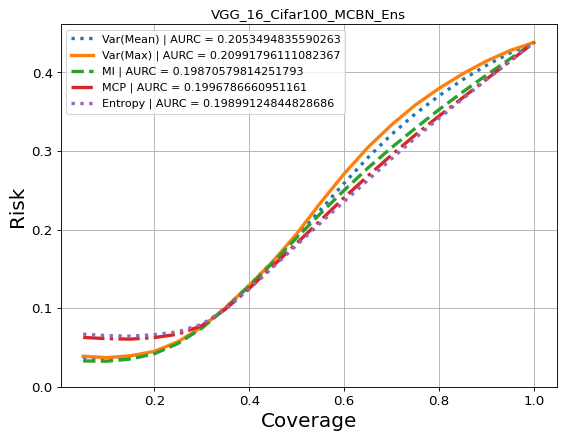

In [28]:
RC.plot_RC(aurc = True)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

#### Deterministic Inference

In [29]:
name = NAME + '_MCBN_Ens'
model_mcbn = MCBN(model,n_samples = N_SAMPLES, as_ensemble = False,name = name, batch_loader = data.train_dataloader).to(dev)
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcbn,corrupted_dataloader)}')

MCD Ensemble Total Accuracy: 54.6


In [ ]:
RC = metrics.selective_metrics(model_mcbn,corrupted_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

In [ ]:
RC.plot_RC(aurc = True)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### Test-time augmentation

In [ ]:
from uncertainty.TestAugmentation import *

c_list = np.arange(0.05,1.05,0.05)
transforms = [F.hflip,
              Scale(1.04),
              Scale(1.1),
              #Rotate(15),
              #Rotate(-15),
              Multiply(0.8),
              Multiply(1.2),
              Add(0.1),
              Add(-0.1),
              FiveCrop(32,4)]

In [ ]:
name = NAME + '_TTA'
TTA_model = TTA.TTA(model,as_ensemble = False, transforms = transforms,name = name).to(dev)

In [ ]:
RC = metrics.selective_metrics(TTA_model,corrupted_dataloader, c_list = c_list)
RC.fix_plot_scale(y_range=(0,rk_model))

In [ ]:
RC.plot_RC(aurc = True)

### MIMO

In [ ]:
from uncertainty.mimo import MIMO_ensemble
N_ENS = 3
name = f'MIMO_{N_ENS}_' + NAME

mimo_path = os.path.join(weights_path,'MIMO')

In [ ]:
mimo_model = MIMO_ensemble(model_class,num_classes = data.n_classes,ensemble_num = N_ENS, name = name, softmax = True)
mimo_model.model.load_state_dict(upload_weights(name, mimo_path))
mimo_model.eval()
TE.model_acc(mimo_model,corrupted_dataloader)

In [ ]:
RC = metrics.selective_metrics(mimo_model,corrupted_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

In [ ]:
RC.plot_RC(aurc = True)